# Sagemaker notebook role setting

In [306]:
from sagemaker import get_execution_role

strSageMakerRoleName = get_execution_role().rsplit('/', 1)[-1]
print (f"SageMaker Execution Role Name: {strSageMakerRoleName}")

SageMaker Execution Role Name: AmazonSageMaker-ExecutionRole-20240423T074145


# Module auto reload

In [307]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: / already exists
sys.path:  ['/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/opt/conda/lib/python3.10/site-packages', '/']


In [309]:
from utils import rag
from utils import opensearch
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

# Install python library

In [9]:
import os
import sys
import IPython
import subprocess

print("installing deps and restarting kernel")
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U awscli
!{sys.executable} -m pip install -U botocore
!{sys.executable} -m pip install -U boto3
!{sys.executable} -m pip install -U sagemaker 
!{sys.executable} -m pip install -U langchain
!{sys.executable} -m pip install -U langchain-community
!{sys.executable} -m pip install -U termcolor
!{sys.executable} -m pip install -U transformers
!{sys.executable} -m pip install -U librosa
!{sys.executable} -m pip install -U opensearch-py
!{sys.executable} -m pip install -U sqlalchemy #==2.0.1
!{sys.executable} -m pip install -U pypdf
#!{sys.executable} -m pip install -U spacy
#!{sys.executable} -m spacy download ko_core_news_md
!{sys.executable} -m pip install -U ipython
!{sys.executable} -m pip install -U ipywidgets
#!{sys.executable} -m pip install -U llmsherpa
!{sys.executable} -m pip install -U anthropic
!{sys.executable} -m pip install -U faiss-cpu
!{sys.executable} -m pip install -U jq
!{sys.executable} -m pip install -U pydantic
!{sys.executable} -m pip install -U langchain-aws
!{sys.executable} -m pip install -U retry
!{sys.executable} -m pip install -U opencv-python

installing deps and restarting kernel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 45.2 MB/s eta 0:00:00:00:0100:01


# Library Version Check && Setup

In [310]:
import boto3
import awscli
import botocore
import langchain
from pprint import pprint
from termcolor import colored

print(f"langchain version check: {langchain.__version__}")
print(f"boto3 version check: {boto3.__version__}")
print(f"botocore version check: {botocore.__version__}")
print(f"awscli version check: {awscli.__version__}")
print (colored("\n== FM lists ==", "green"))


langchain version check: 0.1.16
boto3 version check: 1.34.89
botocore version check: 1.34.89
awscli version check: 1.32.89

== FM lists ==


# Langchain with BedrockChat Test
langchain을 이용하여 beckrock에 요청을 보냅니다. 사용할 모델은 claude3 sonnet입니다.

In [311]:
import boto3
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_aws import ChatBedrock
from botocore.config import Config
retry_config = Config(
        region_name = 'us-west-2',
        retries = {
            'max_attempts': 10,
            'mode': 'standard'
        }
)

boto3_bedrock_runtime = boto3.client("bedrock-runtime", config=retry_config)


model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
model_kwargs =  { 
    "max_tokens": 2048,  # Claude-3 use “max_tokens” However Claud-2 requires “max_tokens_to_sample”.
    "temperature": 0.0,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman"],
}

llm_text = ChatBedrock(
    client=boto3_bedrock_runtime,
    model_id=model_id,
    model_kwargs=model_kwargs,
)

# Invoke Example
messages = [
    ("system", "You are a helpful economic expert."),
    ("human", "{question}"),
]
# messages = [
#     SystemMessage(content="You are a helpful cricket expert."),
#     HumanMessage(content="{question}"),
# ]

query = {"question": "AWS의 한국 투자가 지역사회에 미치는 영향은 무엇입니까?"}

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | llm_text | StrOutputParser()


# Chain Invoke
response = chain.invoke(query)
print(response)

AWS에서는 부하 테스트를 위한 다양한 솔루션을 제공합니다. 대표적인 솔루션으로는 다음과 같습니다.

1. AWS Lambda
AWS Lambda는 서버리스 컴퓨팅 서비스로, 부하 테스트 시나리오를 구현하고 실행할 수 있습니다. Lambda 함수를 작성하여 부하를 생성하고, AWS X-Ray를 사용하여 애플리케이션의 성능을 모니터링할 수 있습니다.

2. Amazon EC2
Amazon EC2 인스턴스를 사용하여 부하 테스트 도구를 설치하고 실행할 수 있습니다. 인기 있는 오픈소스 부하 테스트 도구인 Apache JMeter, Gatling, Locust 등을 사용할 수 있습니다.

3. AWS CodeBuild
AWS CodeBuild는 완전 관리형 빌드 서비스로, 부하 테스트 스크립트를 실행하고 보고서를 생성할 수 있습니다. CodeBuild는 다양한 프로그래밍 언어와 부하 테스트 도구를 지원합니다.

4. AWS DevOps Guru
AWS DevOps Guru는 머신러닝 기반의 클라우드 운영 서비스로, 애플리케이션의 성능 문제를 자동으로 감지하고 해결 방안을 제시합니다. 부하 테스트 중 발생하는 성능 문제를 식별하고 분석하는 데 유용합니다.

5. AWS 파트너 솔루션
AWS는 부하 테스트 전문 파트너 솔루션도 제공합니다. 예를 들어, Gremlin, Neotys, BlazeMeter 등의 솔루션을 AWS 마켓플레이스에서 구매하여 사용할 수 있습니다.

AWS는 부하 테스트를 위한 다양한 서비스와 도구를 제공하므로, 요구사항과 시나리오에 맞는 솔루션을 선택하여 사용할 수 있습니다.


# Depoly ReRanker model (if needed)

In [409]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

# Hub Model configuration. https://huggingface.co/models
hub = {
    'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
    'HF_TASK':'text-classification'
}

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
    transformers_version='4.26.0',
    pytorch_version='1.13.1',
    py_version='py39',
    env=hub,
    role=role, 
)

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
    initial_instance_count=1, # number of instances
    instance_type='ml.g5.xlarge' # instance type
)

print(f'Accept: {predictor.accept}')
print(f'ContentType: {predictor.content_type}')
print(f'Endpoint: {predictor.endpoint}')

--------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Accept: ('application/json',)
ContentType: application/json
Endpoint: huggingface-pytorch-inference-2024-04-24-12-19-07-025


# Put reranker endpoint

In [411]:
ssm = boto3.client('ssm')

module_path = ".."
sys.path.append(os.path.abspath(module_path))

response = ssm.put_parameter(
    Name='reranker_endpoint',
    Value=f'{predictor.endpoint}',
    Type='String',
)


The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Get reranker endpoint

In [412]:

endpoint_name = ssm.get_parameter(
    Name='reranker_endpoint',
    WithDecryption=False
)['Parameter']['Value']


# Unstructured.io

unstructured 라이브러리는 다운스트림 기계 학습 작업에 사용하기 위해 구조화되지 않은 텍스트 문서를 전처리하고 구조화하는 데 도움이 되도록 설계되었습니다. 비정형 라이브러리를 사용하여 처리할 수 있는 문서의 예로는 PDF, XML 및 HTML 문서가 있습니다.

# Install unstructured library
필요한 라이브러리를 설치합니다. 설치 후 커널을 재부팅합니다. 

In [12]:
import subprocess

response = subprocess.run(['cat', '/etc/os-release'], capture_output=True)
response = response.stdout.decode("utf-8")
print(response)

!sudo apt-get install software-properties-common -y
!sudo add-apt-repository ppa:alex-p/tesseract-ocr5 -y
!sudo apt-get update -y
!sudo apt-get install poppler-utils tesseract-ocr -y
!sudo apt-get install libgl1-mesa-glx libglib2.0-0 -y
!sudo apt install libreoffice -y
!{sys.executable} -m pip install -U "unstructured[all-docs]"
!{sys.executable} -m install -U pdf2image
!cd /usr/share/tesseract-ocr/5/tessdata/ && sudo wget https://github.com/tesseract-ocr/tessdata_best/raw/main/kor.traineddata


import IPython
IPython.Application.instance().kernel.do_shutdown(True)

PRETTY_NAME="Ubuntu 22.04.4 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.4 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates dbus dirmngr distro-info-data dmsetup gir1.2-glib-2.0
  gir1.2-packagekitglib-1.0 gnupg gnupg-l10n gnupg-utils gpg gpg-agent
  gpg-wks-client gpg-wks-server gpgconf gpgsm iso-codes libapparmor1
  libappstream4 libargon2-1 libassuan0 libcap2-bin libcryptsetup12 libdbus-1-3
  libdevmapper1.02.1 libdw1 libelf1 libgirepository-1.0-1 libglib2.0-0
  libglib2.0-bin libglib2.0-data libgstreamer1.0-0 libip4tc2 libkmod2 libksba8
  libmpdec3 libnpth0 l

{'status': 'ok', 'restart': True}

# LangChain UnstructuredFileLoader PDF
File loader는 unstructured 파티션 기능을 사용하며 파일 유형을 자동으로 감지합니다. "single" 및 "elements"의 두 가지 모드 중 하나로 로더를 실행할 수 있습니다. "single" 모드를 사용하는 경우 문서는 단일 langchain Document 개체로 반환됩니다. "elements" 모드를 사용하는 경우 unstructured 라이브러리는 문서를 제목 및 NarrativeText와 같은 elements로 분할합니다. 모드 이후에 추가로 unstructured kwargs를 전달하여 다른 unstructured 설정을 적용할 수 있습니다.

## UnstructuredFileLoader Parameter

- filename
    - 대상 파일 이름 경로를 정의하는 문자열.
- content_type
    - MIME 유형의 파일 내용을 정의하는 문자열.
- file
    - "rb" 모드 --> open(filename, "rb")를 사용하는 파일류 객체.
- metadata_filename
    - file이 None이 아닌 경우 요소 메타데이터에 저장할 파일 이름(문자열). 예: "foo.txt"
- url
    - 원격 문서의 URL입니다. 파티션이 문서를 특정 content_type으로 처리하도록 하려면 content_type을 전달
- include_page_breaks
    - True인 경우 파일 형식이 지원하는 경우 출력에 페이지 나누기가 포함.
- strategy
    - PDF/이미지 분할에 사용할 전략. 'hi_res'로 설정된 경우 레이아웃 감지 모델을 사용하고, 그렇지 않으면 파티션은 단순히 문서에서 텍스트를 추출하여 처리.
- encoding
    - 텍스트 입력을 디코딩하는 데 사용되는 인코딩. 없을 경우 utf-8이 사용.
- headers
    - URL이 설정된 경우 HTTP 요청과 함께 사용되는 헤더.
- skip_infer_table_types
    - 테이블 추출을 안할 문서 유형.
- ssl_verify
    - URL이 설정된 경우 파티션이 HTTP 요청에서 SSL 확인을 사용하는지 여부를 결정.
- languages
    - 파티셔닝 및/또는 OCR에 사용하기 위해 문서에 존재하는 언어입니다. Tesseract를 사용하여 이미지 또는 PDF 문서를 분할하려면 먼저 적절한 Tesseract 언어 팩을 설치해야 합니다. 다른 파티션의 경우 'langDetect'를 통해 naive Bayesian 필터를 사용하여 언어가 감지됩니다. 다중 언어는 텍스트가 두 언어 중 하나일 수 있음을 나타냅니다.
    - Additional Parameters: <BR>
        - detect_language_per_element <BR>
            - 문서 수준이 아닌 Elements별로 언어를 감지합니다.
- pdf_infer_table_structure
    - True이고 strategy=hi_res인 경우 PDF에서 추출된 모든 테이블 요소에는 추가 메타데이터 필드인 "text_as_html"이 포함됩니다. 여기서 값(문자열)은 데이터를 HTML <table>로 변환한 것입니다.
    - 분할된 테이블 요소의 "텍스트" 필드는 True이든 False이든 항상 존재합니다.
- extract_image_block_types
    - `strategy=hi_res`인 경우 적용. 이 목록에 지정된 Element유형의 이미지(예: ["Image", "Table"])는 'extract_image_block_output_dir'에 지정된 경로에 저장되거나 base64로 저장됩니다.
- extract_image_block_to_payload
    - Only applicable if `strategy=hi_res`.
    If True, images of the element type(s) defined in 'extract_image_block_types' will be
    encoded as base64 data and stored in two metadata fields: 'image_base64' and
    'image_mime_type'.
    This parameter facilitates the inclusion of element data directly within the payload,
    especially for web-based applications or APIs.
- extract_image_block_output_dir
    - Only applicable if `strategy=hi_res` and `extract_image_block_to_payload=False`.
    The filesystem path for saving images of the element type(s)
    specified in 'extract_image_block_types'.
- xml_keep_tags
    - If True, will retain the XML tags in the output. Otherwise it will simply extract
    the text from within the tags. Only applies to partition_xml.
- request_timeout
    - The timeout for the HTTP request if URL is set. Defaults to None meaning no timeout and
    requests will block indefinitely.
- hi_res_model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`.
    - https://unstructured-io.github.io/unstructured/best_practices/models.html
- model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`. To be
    deprecated in favor of `hi_res_model_name`.

In [380]:
from langchain_community.document_loaders import UnstructuredFileLoader, UnstructuredAPIFileLoader
from unstructured.cleaners.core import clean_bullets, clean_extra_whitespace

output="output" 
file_path="data/1-aws-korea-eis-full-report-korean_removed.pdf"

loader = UnstructuredFileLoader(
    file_path=file_path,
    chunking_strategy = "by_title",
    mode="elements",
    strategy="hi_res",
    hi_res_model_name="yolox",
    extract_images_in_pdf=True,
    pdf_infer_table_structure=True,
    extract_image_block_output_dir=output,
    extract_image_block_to_payload=False,
    languages= ["kor+eng"],
    post_processors=[clean_bullets, clean_extra_whitespace]
)

docs = loader.load()

# Categorize Table && Text && Image

In [381]:
import os
from glob import glob

tables, texts = [], []

for doc in docs:
    category = doc.metadata["category"]
    if category == "Table": tables.append(doc)
    elif category == "Image": images.append(doc)
    else: texts.append(doc)
    images = glob(os.path.join(output, "*"))
    
print (f' # texts: {len(texts)} \n # tables: {len(tables)} \n # images: {len(images)}')

 # texts: 119 
 # tables: 0 
 # images: 45


# Image edit with OpenCV

In [382]:
import cv2
import math
import numpy as np
import shutil

from pdf2image import convert_from_path

image_tmp_path = os.path.join(output, "tmp")
if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
os.mkdir(image_tmp_path)

# from pdf to image
pages = convert_from_path(file_path)
for i, page in enumerate(pages):
    print (f'pdf page {i}, size: {page.size}')    
    page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

print ("==")

#table_images = []
for idx, table in enumerate(tables):
    if "coordinates" in table.metadata :
        points = table.metadata["coordinates"]["points"]
        layout_width, layout_height = table.metadata["coordinates"]["layout_width"], table.metadata["coordinates"]["layout_height"]
    
        page_number = table.metadata["page_number"]
    
        img = cv2.imread(f'{image_tmp_path}/{page_number}.jpg')
        crop_img = img[math.ceil(points[0][1]):math.ceil(points[1][1]), \
                       math.ceil(points[0][0]):math.ceil(points[3][0])]
        table_image_path = f'{output}/table-{idx}.jpg'
        cv2.imwrite(table_image_path, crop_img)
    
        print (f'unstructured width: {layout_width}, height: {layout_height}')
        print (f'page_number: {page_number}')
        print ("==")

if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
#print (f'table_images: {table_images}')
images = glob(os.path.join(output, "*"))
print (f'images: {images}')

pdf page 0, size: (1700, 2200)
pdf page 1, size: (1700, 2200)
pdf page 2, size: (1700, 2200)
pdf page 3, size: (1700, 2200)
pdf page 4, size: (1700, 2200)
pdf page 5, size: (1700, 2200)
pdf page 6, size: (1700, 2200)
pdf page 7, size: (1700, 2200)
pdf page 8, size: (1700, 2200)
pdf page 9, size: (1700, 2200)
pdf page 10, size: (1700, 2200)
pdf page 11, size: (1700, 2200)
pdf page 12, size: (1700, 2200)
pdf page 13, size: (1700, 2200)
pdf page 14, size: (1700, 2200)
pdf page 15, size: (1700, 2200)
pdf page 16, size: (1700, 2200)
pdf page 17, size: (1700, 2200)
pdf page 18, size: (1700, 2200)
pdf page 19, size: (1700, 2200)
pdf page 20, size: (1700, 2200)
pdf page 21, size: (1700, 2200)
pdf page 22, size: (1700, 2200)
pdf page 23, size: (1700, 2200)
pdf page 24, size: (1700, 2200)
pdf page 25, size: (1700, 2200)
pdf page 26, size: (1700, 2200)
pdf page 27, size: (1700, 2200)
pdf page 28, size: (1700, 2200)
pdf page 29, size: (1700, 2200)
pdf page 30, size: (1700, 2200)
pdf page 31, size:

# Resize images (sclae down)

In [383]:
for image in images:
    
    img = cv2.imread(image) 
    width, height, _ = img.shape
    image_token = width*height/750
    print (f'image: {image}, shape: {img.shape}, image_token_for_claude3: {image_token}' )
    
    if image_token > 1500:
        resize_img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
        print("   - resize_img.shape = {0}".format(resize_img.shape))
        table_image_path = image.replace(".jpg", "-resize.jpg")
        cv2.imwrite(table_image_path, resize_img)
        os.remove(image)
    
    images = glob(os.path.join(output, "*"))

image: output/figure-10-1.jpg, shape: (654, 1516, 3), image_token_for_claude3: 1321.952
image: output/figure-30-4.jpg, shape: (503, 1240, 3), image_token_for_claude3: 831.6266666666667
image: output/figure-31-5.jpg, shape: (570, 1213, 3), image_token_for_claude3: 921.88
image: output/figure-38-6.jpg, shape: (607, 1380, 3), image_token_for_claude3: 1116.88
image: output/figure-59-7.jpg, shape: (275, 1376, 3), image_token_for_claude3: 504.53333333333336
image: output/figure-28-2-resize.jpg, shape: (486, 738, 3), image_token_for_claude3: 478.224
image: output/figure-29-3-resize.jpg, shape: (426, 689, 3), image_token_for_claude3: 391.352
image: output/figure-6-1.jpg, shape: (654, 1516, 3), image_token_for_claude3: 1321.952
image: output/figure-26-4.jpg, shape: (503, 1240, 3), image_token_for_claude3: 831.6266666666667
image: output/figure-27-5.jpg, shape: (570, 1213, 3), image_token_for_claude3: 921.88
image: output/figure-34-6.jpg, shape: (607, 1380, 3), image_token_for_claude3: 1116.88
i

# Summarization of table and image
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca

In [384]:
from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

# Generate Image infomation with Amazon Bedrock(claude3)
리사이징한 이미지를 langchain을 이용해 bedrock으로 보냅니다. claude3를 통해 이미지를 요약하여 다시 재정렬합니다. 

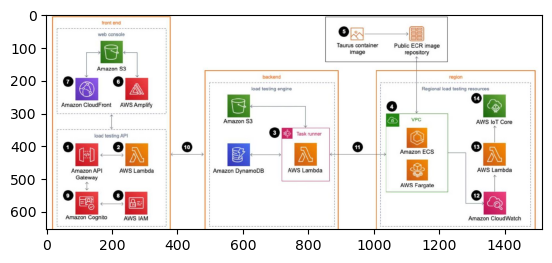

이 이미지는 AWS 클라우드 서비스를 활용한 로드 테스팅 시스템의 아키텍처를 보여줍니다. 프론트엔드에는 웹 콘솔, Amazon S3, AWS Amplify, Amazon CloudFront, 로드 테스팅 API, Amazon API Gateway, AWS Lambda, Amazon Cognito, AWS IAM 등이 있습니다. 백엔드에는 로드 테스팅 엔진, Amazon S3, Amazon DynamoDB, AWS Lambda, Task runner 등이 있습니다. 리전에는 VPC, Amazon ECS, AWS Fargate, AWS IoT Core, AWS Lambda, Amazon CloudWatch 등의 리소스가 있습니다. 또한 Taurus 컨테이너와 Public ECR 이미지 저장소도 포함되어 있습니다.

==


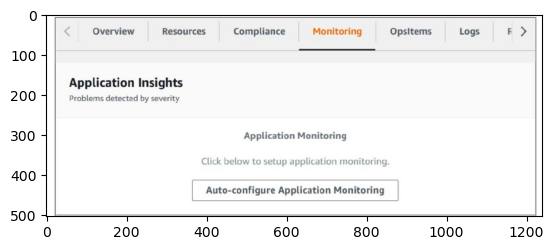

이미지는 애플리케이션 인사이트 모니터링 대시보드를 보여주고 있습니다. 상단에는 개요, 리소스, 컴플라이언스, 모니터링, OpsItems, 로그 등의 메뉴가 있습니다. 중앙에는 애플리케이션 모니터링 설정을 위한 "Auto-configure Application Monitoring" 버튼이 있습니다. 이 대시보드를 통해 애플리케이션의 문제를 심각도 별로 감지하고 모니터링할 수 있습니다.

==


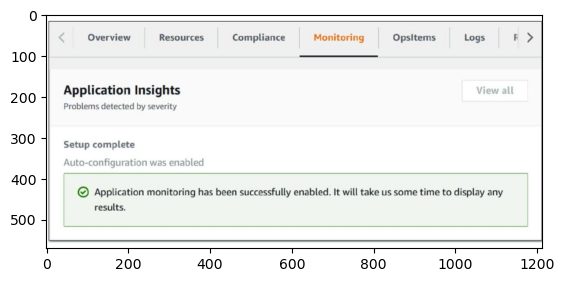

이미지는 애플리케이션 모니터링 대시보드의 일부를 보여주고 있습니다. 상단에는 개요, 리소스, 컴플라이언스, 모니터링, OpsItems, 로그 등의 탭이 있습니다. 중앙에는 애플리케이션 인사이트 섹션이 있으며, 자동 구성이 활성화되었고 애플리케이션 모니터링이 성공적으로 활성화되었다는 메시지가 표시되어 있습니다. 하지만 결과를 표시하는 데 시간이 걸릴 것이라고 설명하고 있습니다.

==


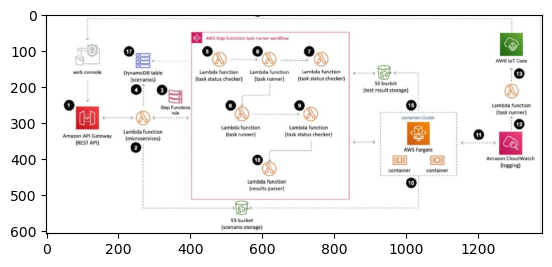

이 이미지는 AWS Step Functions 작업 실행기 워크플로우를 보여주고 있습니다. 웹 콘솔에서 DynamoDB 테이블의 시나리오를 가져와 API Gateway를 통해 마이크로서비스 Lambda 함수를 호출합니다. 그 후 여러 Lambda 함수(작업 실행기, 작업 상태 확인기, 결과 파서 등)가 작업을 처리하고, 결과를 S3 버킷에 저장합니다. 또한 AWS IoT Core, AWS Fargate의 컨테이너 클러스터, Amazon CloudWatch 로깅 등의 AWS 서비스들이 통합되어 있습니다. 전체적으로 서버리스 아키텍처를 활용한 작업 실행 및 모니터링 워크플로우를 나타내고 있습니다.

==


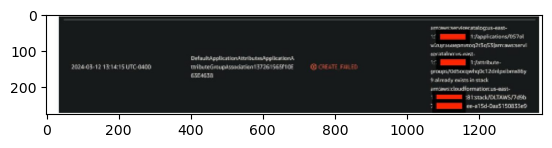

이미지는 검은색 배경에 빨간색과 흰색 텍스트로 구성된 코드 스니펫 또는 터미널 출력을 보여주고 있습니다. 이는 프로그램 실행 시 발생하는 오류 메시지나 디버깅 정보를 나타내는 것으로 보입니다. 코드 실행 중 발생한 문제를 식별하고 해결하는 데 사용되는 개발자 도구의 일부분을 보여주는 것 같습니다.

==


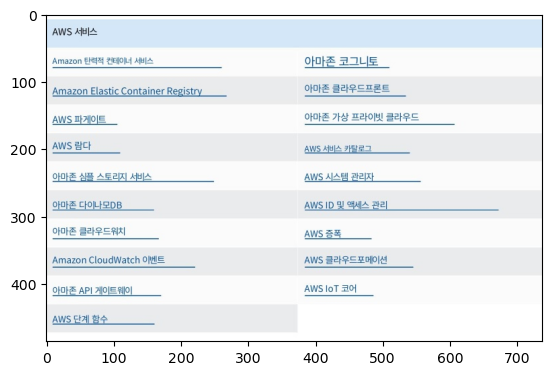

이미지는 AWS(아마존 웹 서비스)에서 제공하는 다양한 서비스 목록을 보여주고 있습니다. 서비스 목록에는 Amazon Elastic Container Registry, AWS 파이프라인, AWS 람다, 아마존 심플 스토리지 서비스, 아마존 DynamoDB, 아마존 클라우드워치, Amazon CloudWatch 이벤트, 아마존 API 게이트웨이, AWS 데브 옵스 등이 포함되어 있습니다. 이 목록을 통해 AWS에서 제공하는 다양한 클라우드 컴퓨팅, 스토리지, 데이터베이스, 모니터링 등의 서비스를 확인할 수 있습니다.

==


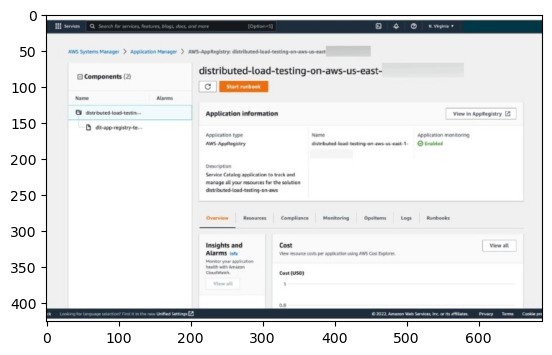

이 이미지는 AWS 시스템 관리자의 애플리케이션 관리자 화면을 보여주고 있습니다. 화면에는 "distributed-load-testing-on-aws-us-east-1"이라는 애플리케이션의 정보와 상태, 비용 등의 세부 정보가 표시되어 있습니다. 이 애플리케이션은 로드 테스트를 위한 것으로 보이며, 리소스 관리와 모니터링을 위한 다양한 기능들이 제공되는 것 같습니다.

==


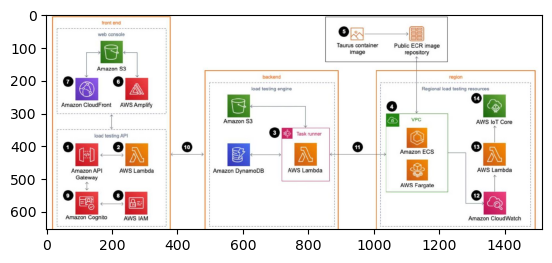

이 이미지는 AWS 클라우드 서비스를 활용한 로드 테스팅 시스템의 아키텍처를 보여줍니다. 프론트엔드에는 웹 콘솔, Amazon S3, AWS Amplify, Amazon CloudFront, API Gateway, AWS Lambda, Amazon Cognito, AWS IAM 등의 서비스가 사용됩니다. 백엔드에는 로드 테스팅 엔진, Amazon S3, Amazon DynamoDB, AWS Lambda, Task runner 등이 있습니다. 리전에는 VPC, Amazon ECS, AWS Fargate, AWS IoT Core, AWS Lambda, Amazon CloudWatch 등의 리소스가 배치되어 있습니다. 이 아키텍처를 통해 로드 테스팅을 효율적으로 수행할 수 있습니다.

==


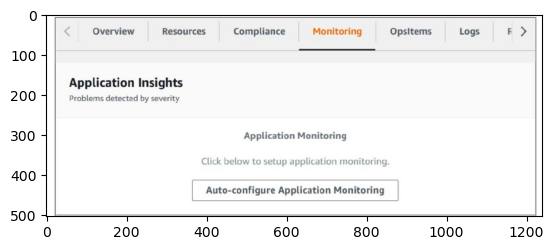

이미지는 애플리케이션 인사이트 모니터링 대시보드를 보여주고 있습니다. 상단에는 개요, 리소스, 컴플라이언스, 모니터링, OpsItems, 로그 등의 메뉴가 있습니다. 중앙에는 애플리케이션 모니터링 섹션이 있으며, "Auto-configure Application Monitoring" 버튼을 클릭하여 애플리케이션 모니터링을 설정할 수 있습니다. 이 대시보드를 통해 애플리케이션의 문제를 심각도 별로 감지하고 모니터링할 수 있습니다.

==


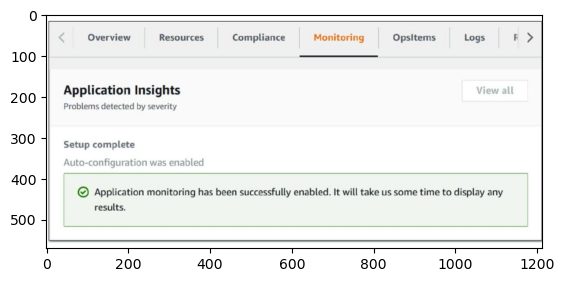

이미지는 애플리케이션 모니터링 대시보드의 일부를 보여주고 있습니다. 상단에는 개요, 리소스, 컴플라이언스, 모니터링, OpsItems, 로그 등의 탭이 있습니다. 중앙에는 애플리케이션 인사이트 섹션이 있으며, 자동 구성이 활성화되었고 애플리케이션 모니터링이 성공적으로 활성화되었다는 메시지가 표시되어 있습니다. 하지만 결과를 표시하는 데 시간이 걸릴 것이라고 설명하고 있습니다.

==


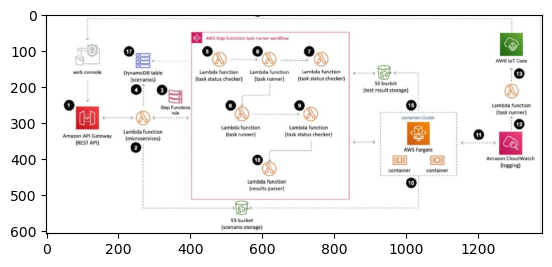

이 이미지는 AWS Step Functions 작업 실행기 워크플로우를 보여주고 있습니다. 웹 콘솔에서 DynamoDB 테이블의 시나리오를 가져와 API Gateway를 통해 마이크로서비스 Lambda 함수를 호출합니다. 그 후 여러 Lambda 함수(작업 실행기, 작업 상태 확인기, 결과 파서 등)가 작업을 처리하고, 결과를 S3 버킷에 저장합니다. 또한 AWS IoT Core, AWS Fargate의 컨테이너 클러스터, Amazon CloudWatch 로깅 등의 AWS 서비스들이 통합되어 있습니다. 전체적으로 서버리스 아키텍처를 활용한 작업 실행 및 모니터링 워크플로우를 나타내고 있습니다.

==


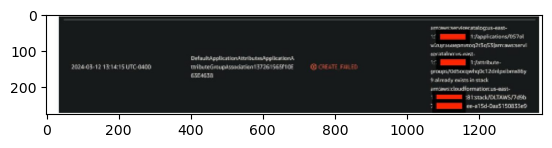

이미지는 검은색 배경에 빨간색과 흰색 텍스트로 구성된 코드 스니펫 또는 터미널 출력을 보여주고 있습니다. 이는 프로그램 실행 시 발생하는 오류 메시지나 디버깅 정보를 나타내는 것으로 보입니다. 코드 실행 중 발생한 문제를 식별하고 해결하는 데 사용되는 개발자 도구의 일부분을 보여주는 것 같습니다.

==


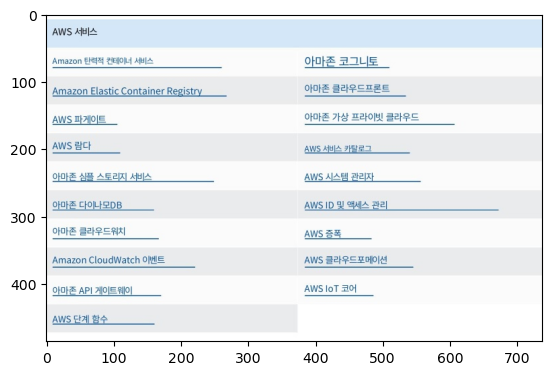

이미지는 AWS(아마존 웹 서비스)에서 제공하는 다양한 서비스 목록을 보여주고 있습니다. 서비스 목록에는 Amazon Elastic Container Registry, AWS 파이프라인, AWS 람다, 아마존 심플 스토리지 서비스, 아마존 DynamoDB, 아마존 클라우드워치, Amazon CloudWatch 이벤트, 아마존 API 게이트웨이, AWS 데브 허브 등이 포함되어 있습니다. 이를 통해 AWS에서 제공하는 클라우드 컴퓨팅, 스토리지, 데이터베이스, 모니터링 등 다양한 서비스를 확인할 수 있습니다.

==


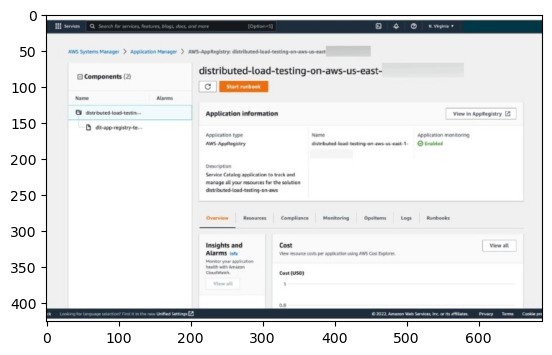

이 이미지는 AWS 시스템 관리자의 애플리케이션 관리자 화면을 보여주고 있습니다. 화면에는 "distributed-load-testing-on-aws-us-east-1"이라는 애플리케이션의 정보와 상태, 비용 등의 세부 정보가 표시되어 있습니다. 이 애플리케이션은 로드 테스트를 위한 것으로 보이며, 리소스 관리와 모니터링을 위한 다양한 기능들이 제공되는 것 같습니다.

==


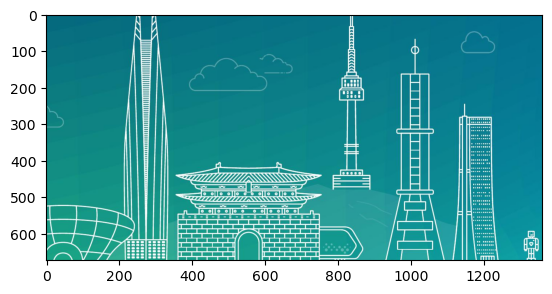

이미지는 서울의 유명한 랜드마크들을 단순화된 라인 아트 스타일로 묘사하고 있습니다. 왼쪽에는 롯데월드타워, 가운데에는 N서울타워와 경복궁, 오른쪽에는 63빌딩과 기타 고층 빌딩들이 있습니다. 전체적으로 서울의 도시 스카이라인과 대표적인 건축물들을 미니멀한 방식으로 표현하고 있습니다.

==


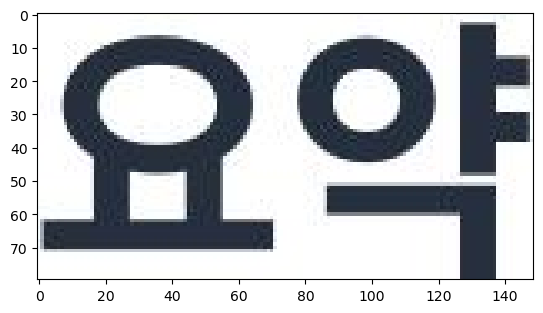

주어진 이미지는 한글 '아'와 '야'의 모습을 단순하고 기하학적인 형태로 표현한 것으로 보입니다. 검은색 원과 직선으로 이루어져 있으며, 한글 글자의 기본 구조를 추상화하여 나타내고 있습니다. 이 이미지는 한글 문자의 시각적 특성을 현대적이고 미니멀한 방식으로 재해석한 디자인 작품으로 여겨집니다.

==


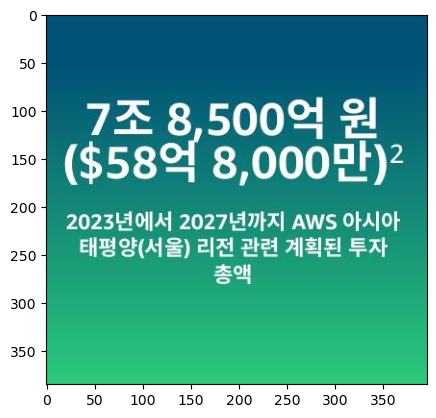

이미지는 2023년에서 2027년까지 AWS 아시아 태평양(서울) 리전 관련 계획된 투자 총액이 7조 8,500억 원(약 58억 8,000만 달러)임을 보여주고 있습니다. 이는 AWS가 한국 클라우드 시장에 대한 지속적인 투자 의지를 나타내는 것으로 보입니다.

==


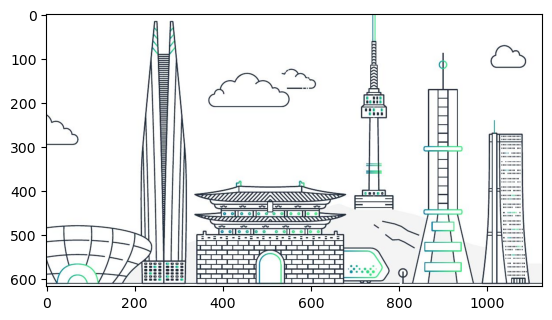

이미지는 서울의 유명한 랜드마크들을 선으로 간단하게 묘사하고 있습니다. 왼쪽부터 롯데월드타워, 경복궁, N서울타워, 63빌딩, 그리고 여러 고층 빌딩들이 있습니다. 전체적으로 서울의 대표적인 현대 건축물과 전통 건축물이 조화롭게 그려져 있는 모습입니다.

==


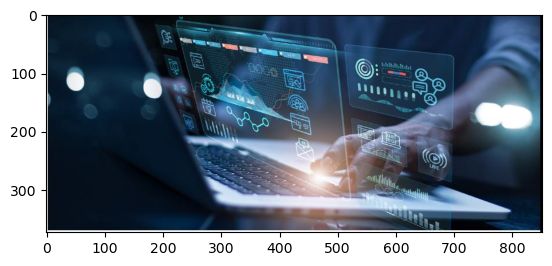

이미지는 현대적인 기술 인터페이스를 보여주고 있습니다. 노트북 화면에는 차트, 그래프, 아이콘 등 다양한 데이터 시각화 요소가 표시되어 있습니다. 손은 가상 홀로그램 인터페이스를 조작하는 모습입니다. 이 이미지는 첨단 기술과 데이터 분석의 개념을 나타내고 있습니다.

==


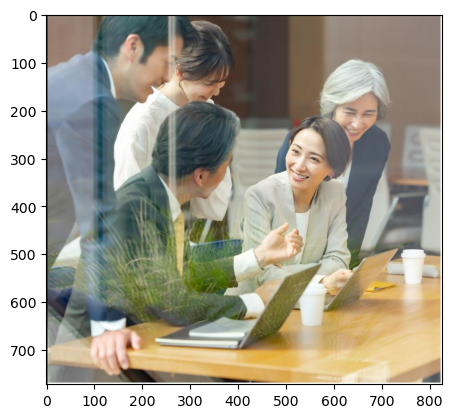

이 이미지는 젊은 직장인들이 회의실에서 미팅을 하고 있는 모습을 보여줍니다. 그들은 노트북과 문서를 보며 열심히 토론하고 있습니다. 모두 편안한 옷차림을 하고 있으며 밝고 긍정적인 분위기를 풍기고 있습니다. 이 장면은 현대 직장 문화에서 협업과 소통의 중요성을 잘 보여주고 있습니다.

==


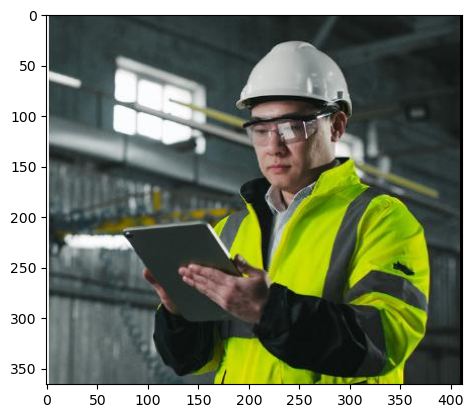

이 이미지는 안전모와 반사 조끼를 착용한 남성 작업자가 태블릿 PC를 들고 있는 모습을 보여줍니다. 그는 공장 또는 건설 현장과 같은 산업 환경에 있는 것으로 보입니다. 작업자는 태블릿을 통해 데이터를 확인하거나 작업 지시를 받고 있는 것 같습니다. 이 장면은 현장 작업 중 기술 활용과 안전 관리의 중요성을 보여줍니다.

==


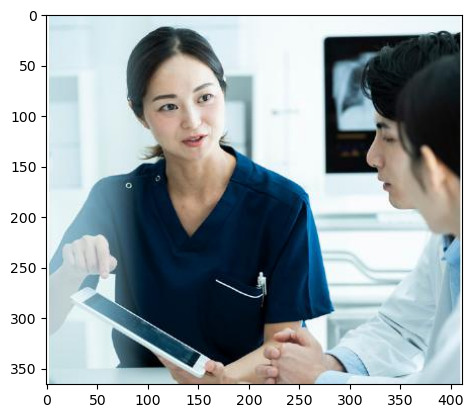

이미지에는 의사와 환자가 대화하는 모습이 나타나 있습니다. 의사는 파란색 가운을 입고 있으며 태블릿 PC를 들고 있습니다. 환자는 병원 침대에 누워 있으며 의사와 상담하는 모습입니다. 의사와 환자 간의 진료 장면을 보여주고 있습니다.

==


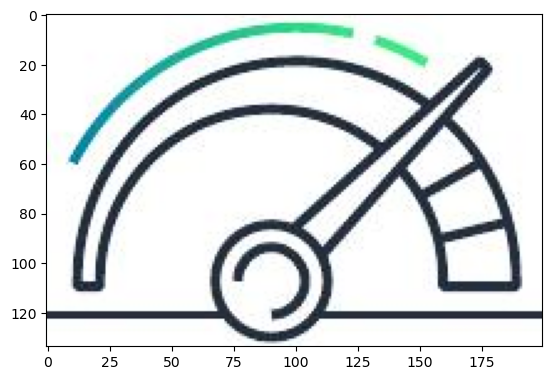

주어진 이미지는 간단한 선 그림으로, 잔디밭을 관리하는 데 사용되는 수동 잔디 깎는 기계인 잔디 깎는 기구를 나타냅니다. 이 기구는 바퀴가 달린 원통형 몸체와 손잡이로 구성되어 있습니다. 사람들이 손으로 밀면서 잔디를 깎을 수 있는 전통적인 도구입니다.

==


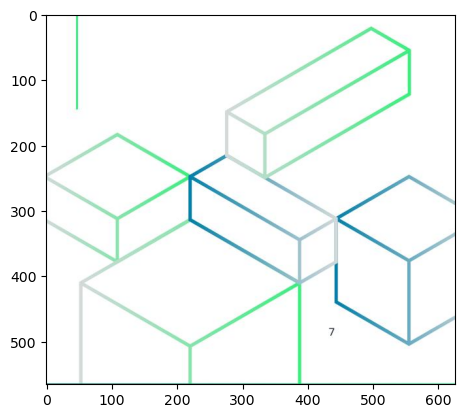

이미지는 녹색과 파란색 선으로 이루어진 3차원 큐브 모양의 도형을 보여주고 있습니다. 큐브들이 서로 연결되어 있으며, 한 큐브에는 숫자 7이 표시되어 있습니다. 전체적으로 단순하고 기하학적인 모습을 하고 있습니다.

==


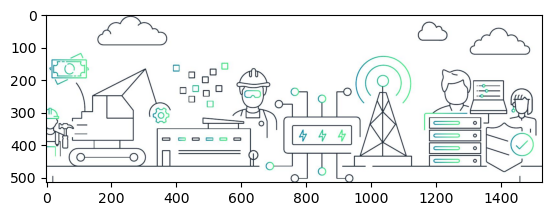

이 이미지는 에너지 산업과 관련된 다양한 요소들을 선과 아이콘으로 표현하고 있습니다. 건물, 발전소, 송전탑, 컴퓨터 및 기술자 등이 포함되어 있어 에너지 생산, 전송 및 관리 과정을 나타내고 있습니다. 전반적으로 현대 에너지 인프라와 기술을 단순화된 스타일로 묘사하고 있습니다.

==


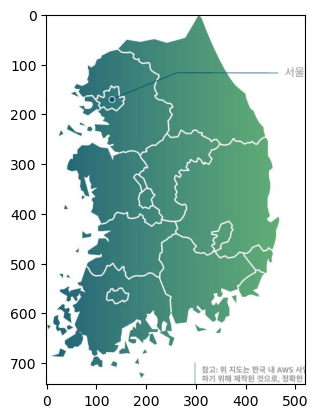

이 이미지는 대한민국의 지도를 보여주고 있습니다. 지도에는 서울과 여러 지역이 경계선으로 구분되어 있습니다. 지도의 오른쪽 상단에는 '서울'이라는 글자가 표시되어 있고, 아래쪽에는 '협곡 및 지도도 한국 내 AWS 서비스 제공 지역'이라는 설명이 있습니다. 전체적으로 녹색 계열의 색상으로 표현되어 있습니다.

==


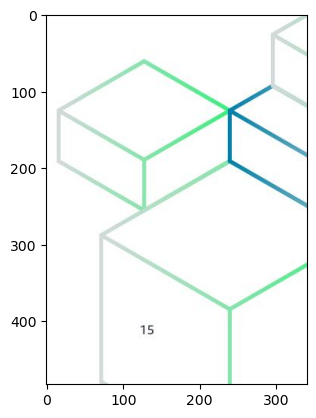

이미지는 녹색과 파란색 선으로 이루어진 3차원 입체 도형을 보여주고 있습니다. 큰 정사각형 모양의 상자 위에 작은 직사각형 모양의 상자가 연결되어 있는 구조입니다. 숫자 15가 작은 상자 아래에 표시되어 있습니다. 이 이미지는 아마도 3차원 모델링이나 건축 설계와 관련된 것으로 보입니다.

==


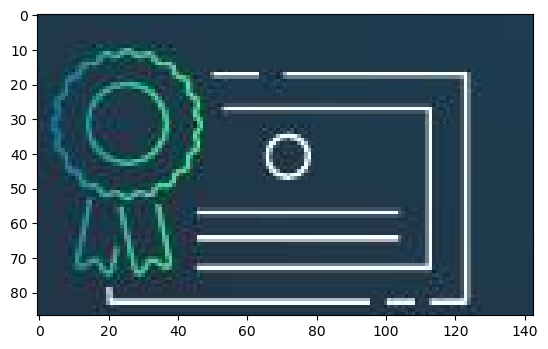

주어진 이미지는 인증서나 자격증을 상징하는 간단한 아이콘입니다. 리본 모양의 상징과 문서 모양의 직사각형이 있으며, 전체적으로 청록색 계열의 라인 아트로 표현되어 있습니다. 이 이미지는 인증, 승인, 자격 등의 개념을 시각적으로 나타내고 있습니다.

==


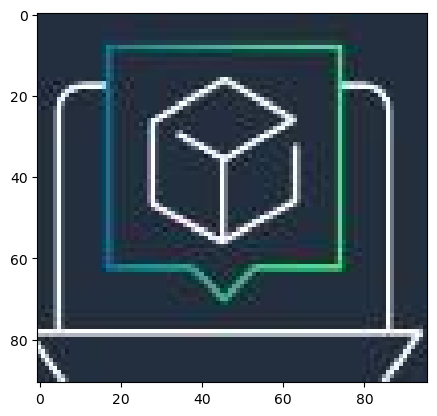

주어진 이미지는 3차원 큐브 모양의 기하학적 도형과 여러 가지 색상의 네온 조명 효과를 결합한 추상적인 디자인입니다. 이 이미지는 미래지향적이고 첨단기술적인 분위기를 연출하며, 로고나 브랜딩 디자인 등에 활용될 수 있을 것 같습니다.

==


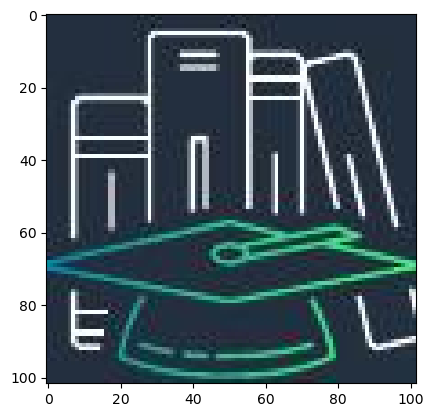

주어진 이미지는 간단한 선 그림으로 가전제품들을 나타내고 있습니다. 냉장고, 오븐, 식기세척기, 전자레인지 등의 주방 가전제품들과 세탁기, 건조기 등의 가정용 가전제품들이 표현되어 있습니다. 이 그림은 가정에서 사용되는 다양한 가전제품들을 상징적으로 보여주고 있습니다.

==


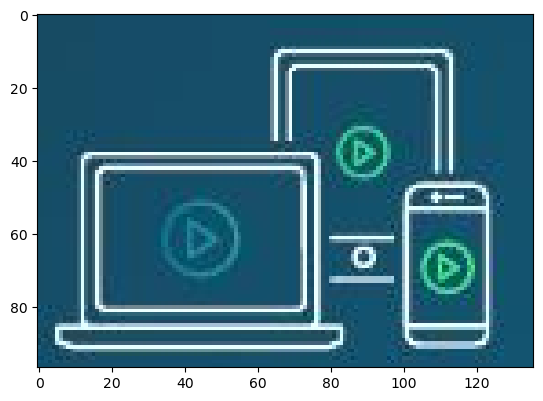

이미지는 노트북, 태블릿, 스마트폰 등 다양한 기기에서 동영상 재생 아이콘을 나타내고 있습니다. 이는 모바일 기기와 데스크톱에서 동영상 콘텐츠를 시청할 수 있음을 암시하는 간단하고 미니멀한 디자인의 그래픽입니다. 전반적으로 디지털 미디어 소비와 관련된 개념을 시각적으로 표현하고 있습니다.

==


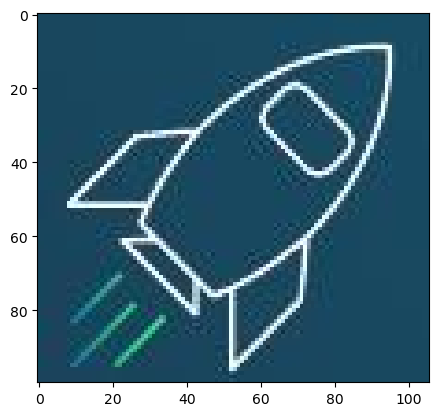

주어진 이미지는 녹색 로켓 모양의 아이콘을 보여주고 있습니다. 이 아이콘은 단순하고 미니멀한 디자인으로 새로운 시작, 발사, 성장 등을 상징하는 것으로 보입니다. 로켓 모양은 일반적으로 비즈니스나 프로젝트의 시작을 나타내는 데 자주 사용되는 상징적인 이미지입니다.

==


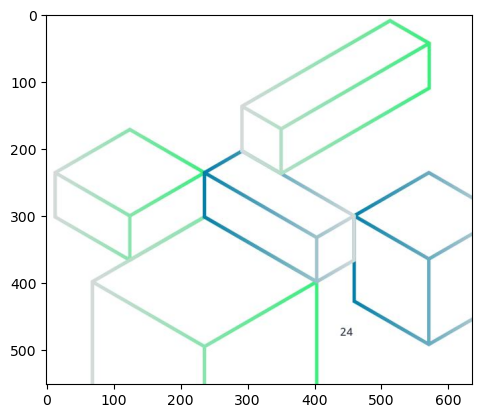

이미지는 녹색과 파란색 직사각형 모양의 상자들로 구성되어 있습니다. 상자들은 서로 연결되어 있으며, 가운데 상자에는 숫자 24가 표시되어 있습니다. 이 이미지는 데이터 구조나 네트워크 다이어그램을 나타내는 것 같습니다.

==


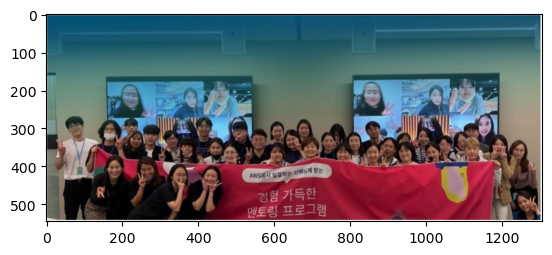

이미지는 많은 사람들이 모여 있는 단체 사진을 보여줍니다. 그들은 빨간색 배너를 들고 있으며, 배너에는 "AWS에서 열렸던 실력 있는 멘토링 프로그램"이라는 문구가 적혀 있습니다. 참가자들은 미소를 지으며 카메라를 향해 손을 흔들고 있습니다. 뒤편 화면에는 세 명의 여성이 보이는데, 아마도 이 프로그램의 강사나 진행자일 것 같습니다. 전체적으로 즐겁고 긍정적인 분위기를 느낄 수 있습니다.

==


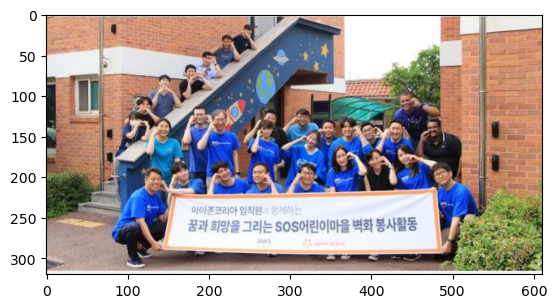

이 이미지는 한 단체의 구성원들이 건물 앞에서 단체 활동을 기념하며 기념 촬영을 하고 있는 모습을 보여줍니다. 구성원들은 파란색 단체복을 입고 있으며, 배너를 들고 있습니다. 이 단체는 아마도 어린이나 청소년 관련 단체일 것으로 보입니다. 구성원들은 활기차 보이며 단체 활동에 대한 열정을 엿볼 수 있습니다.

==


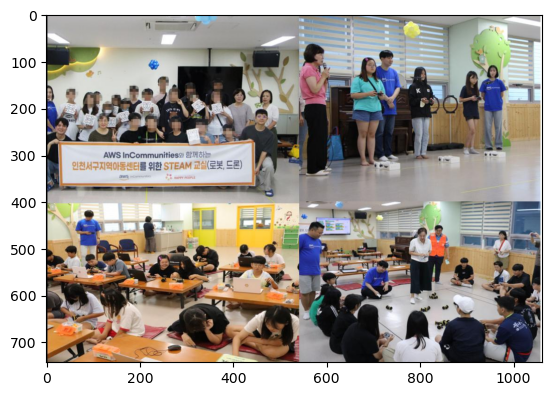

이 이미지는 AWS InCommunities가 주최한 인천서구지역아동센터의 STEAM 교실 모습을 보여줍니다. 아이들이 교실에서 다양한 활동을 하고 있으며, 강사들이 수업을 진행하고 있습니다. 아이들은 열심히 수업에 참여하고 있으며, 교실 분위기는 활기차고 즐거운 모습입니다. 이 프로그램을 통해 아이들이 과학, 기술, 공학, 예술, 수학 등 다양한 분야를 체험하고 배울 수 있는 기회를 제공받고 있습니다.

==


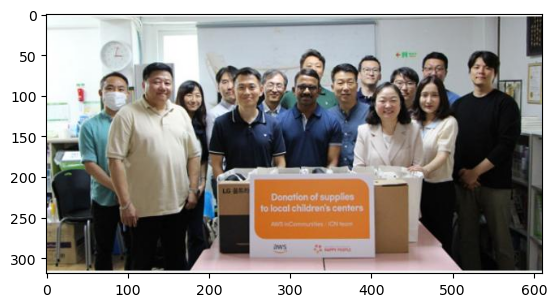

이 이미지는 아시아계 사람들이 어린이 센터에 물품을 기부하는 모습을 보여줍니다. 그들은 마스크를 착용하고 있으며, 오렌지색 박스에는 "어린이 센터에 물품 기부"라는 문구가 적혀 있습니다. 이 장면은 지역사회에 대한 나눔과 배려 정신을 보여주고 있습니다.

==


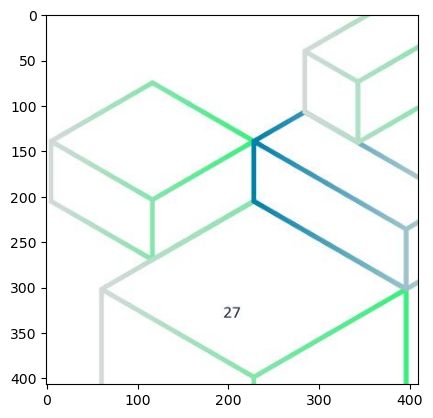

이미지는 녹색과 파란색 선으로 이루어진 입체적인 큐브 모양의 도형을 보여주고 있습니다. 중앙에는 숫자 27이 표시되어 있습니다. 이 이미지는 3차원 공간에서의 구조나 연결 관계를 시각적으로 표현한 것으로 보입니다.

==


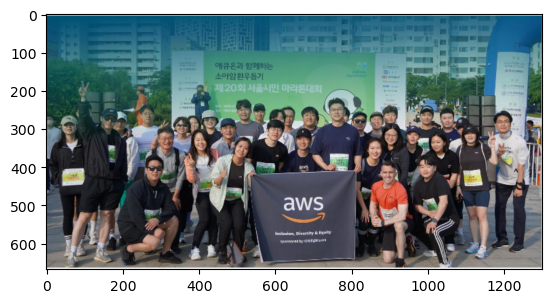

이 이미지는 AWS(아마존 웹 서비스) 직원들이 모여 단체 사진을 찍은 것으로 보입니다. 그들은 다양성과 포용성을 강조하는 AWS 배너를 들고 있습니다. 배경에는 고층 건물과 나무들이 보이며, 그들은 행사 현수막 앞에서 기념 촬영을 하고 있습니다. 전체적으로 다양한 연령과 인종의 사람들이 모여 있는 모습을 볼 수 있습니다.

==


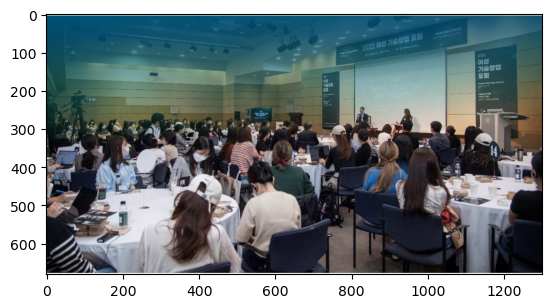

이 이미지는 대규모 회의실 또는 강연장에서 열린 행사의 모습을 보여줍니다. 많은 청중들이 의자에 앉아 있고, 무대 앞에는 발표자들이 마이크를 들고 있습니다. 벽면에는 행사 관련 안내문이 게시되어 있습니다. 대부분의 참석자들은 마스크를 착용하고 있어 코로나19 상황에서 열린 행사임을 알 수 있습니다. 전체적으로 공식적인 분위기의 대규모 회의나 세미나 장면으로 보입니다.

==


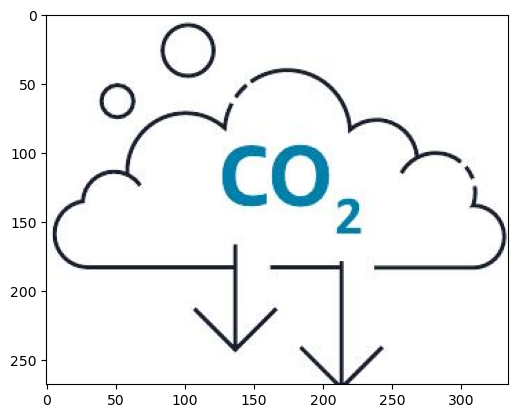

이미지는 이산화탄소(CO2)가 구름 모양에서 아래로 내려오는 모습을 단순화하여 나타낸 것입니다. 이는 대기 중 이산화탄소 배출과 관련된 개념을 시각적으로 표현한 것으로 보입니다. 구름 모양과 화살표를 사용하여 이산화탄소가 대기 중으로 방출되는 과정을 간단하게 묘사하고 있습니다.

==


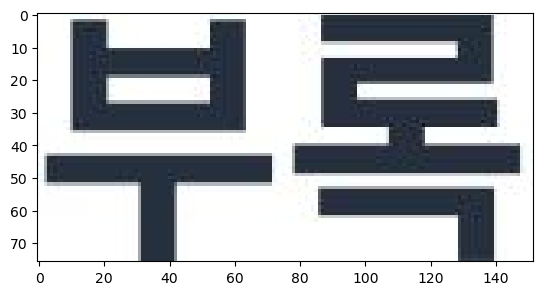

주어진 이미지는 검은색 직사각형 모양의 블록들로 구성되어 있습니다. 이 블록들은 "H", "E", "L", "L", "O"라는 글자를 형상화하고 있습니다. 전체적으로 "HELLO"라는 단어를 표현하는 미니멀한 디자인의 이미지입니다.

==


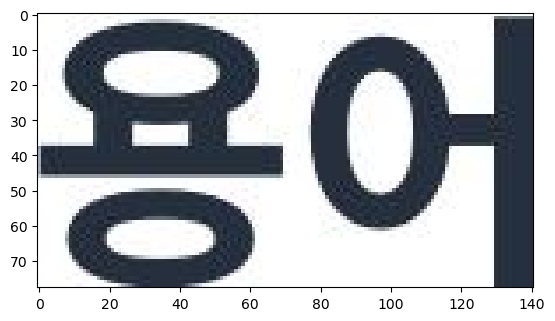

주어진 이미지는 한글 '공여'라는 단어를 나타내고 있습니다. 검은색과 회색 톤의 단순한 서체로 표현되어 있으며, 배경은 없습니다. 이 이미지는 간결하고 미니멀한 스타일로 디자인되어 있습니다.

==


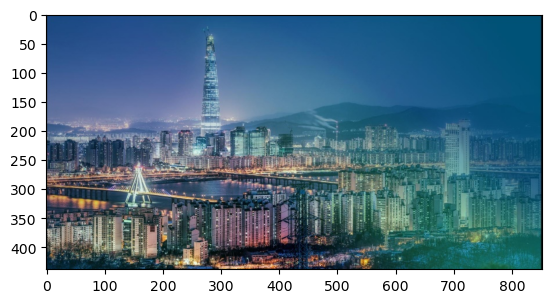

이 이미지는 밤에 촬영된 서울의 아름다운 스카이라인을 보여줍니다. 한강 반영과 반짝이는 빌딩 불빛이 도시의 활기찬 모습을 잘 드러내고 있습니다. 특히 롯데월드타워가 두드러지게 보이며 서울의 상징적인 건축물로 자리잡고 있습니다. 전체적으로 현대적이고 발전된 대도시의 모습을 인상적으로 담아내고 있는 아름다운 야경 사진입니다.

==


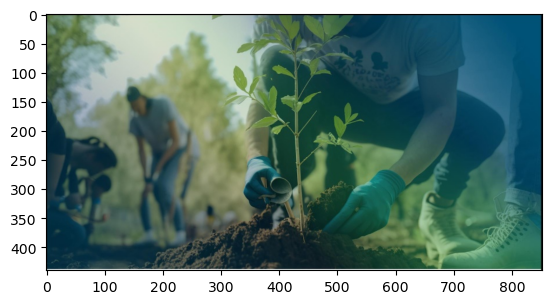

이 이미지는 사람들이 나무를 심는 모습을 보여줍니다. 앞쪽에는 한 사람이 작은 나무 묘목을 심고 있고, 뒤쪽에서는 다른 사람들이 나무 심기 활동을 하고 있습니다. 이 장면은 환경 보호와 녹화 사업을 상징하는 것 같습니다. 사람들은 열심히 땅을 파고 나무를 심으며 자연 보호에 힘쓰고 있는 모습입니다.

==


In [385]:
import time
import base64
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore
from retry import retry

def image_to_base64(output):
    with open(output, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
    return encoded_string.decode('utf-8')


@retry(tries=5, delay=10)
def summary_img(chain, img_base64):

    img = Image.open(BytesIO(base64.b64decode(img_base64)))
    plt.imshow(img)
    plt.show()

    summary = chain.invoke(
        {
            "image_base64": img_base64
        }
    )

    return summary
    
human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 Given image, give a concise summary.
                 Don't insert any XML tag such as <text> and </text> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)
summarize_chain = prompt | llm_text | StrOutputParser()

img_info = [image_to_base64(img_path) for img_path in images]


    
image_summaries = []
for img_base64 in img_info:
    summary = summary_img(summarize_chain, img_base64)
    image_summaries.append(summary)
    print(summary)
    print ("\n==")
    
#image_summaries = summarize_chain.batch(img_info, config={"max_concurrency": 1})

# Generate Image Metadata
요약된 내용을 Document의 page_content로, OCR결과는 metadata의 origin_image로 사용합니다.

In [386]:
images_preprocessed = []

for img_path, image_base64, summary in zip(images, img_info, image_summaries):
    
    metadata = {}
    metadata["img_path"] = img_path
    metadata["category"] = "Image"
    metadata["image_base64"] = image_base64
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

# Table Summerize with Amazon Bedrock
Bedrock을 사용하여 테이블의 정보도 요약합니다.

In [387]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

table_info = [t.page_content for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})

In [388]:
for t in table_info:
    print("table : " + t )

# Table summary
`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [389]:
tables_preprocessed = []

for origin, summary in zip(tables, table_summaries):
    metadata = origin.metadata
    metadata["origin_table"] = origin.page_content
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)

# RecursiveCharacterTextSplitter 로 청킹
이 텍스트 분할기는 일반 텍스트에 권장되는 것입니다. 문자 목록으로 매개변수화됩니다. 청크가 충분히 작아질 때까지 순서대로 분할하려고 시도합니다. 기본 구분 기호 목록은 ["\n\n", "\n", " ", ""]입니다. 이는 모든 단락(그리고 문장, 단어)을 가능한 한 길게 같이 유지하려는 효과가 있고, 일반적으로 이러한 단락은 의미상 가장 강력한 관련 텍스트인 것처럼 보이기 때문입니다.

텍스트 분할 방법: 문자 목록 기준(by list of characters)
청크 크기 측정 방법: 문자 수 기준(by number of characters)

여기서 알아야 할 중요한 매개변수는 ChunkSize와 ChunkOverlap입니다. ChunkSize는 최종 문서의 최대 크기(문자 수 기준)를 제어합니다. ChunkOverlap은 청크 사이가 얼마나 겹치는지를 지정합니다. 이는 텍스트가 이상하게 분할되지 않도록 하는 데 종종 도움이 됩니다. 아래 예에서는 이러한 값을 작게 설정했지만(설명 목적으로) 실제로는 기본값이 각각 1000과 200입니다.

In [390]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

chunk_size = 1024
chunk_overlap = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["\n\n", "\n", ".", " ", ""],
    length_function=len,
)

texts_preprocessed = text_splitter.split_documents(texts)
print(f"Number of documents after split and chunking={len(texts_preprocessed)}")



Number of documents after split and chunking=119


### Merge text, table and image

In [391]:
from itertools import chain
docs_preprocessed = list(chain(texts_preprocessed, tables_preprocessed, images_preprocessed))

# Create OpenSearch

In [392]:
import boto3
import uuid
import botocore
import time
DEV = True # True일 경우 1-AZ without standby로 생성, False일 경우 3-AZ with standby. 워크샵 목적일 때는 지나친 과금/리소스 방지를 위해 True로 설정하는 것을 권장
VERSION = "2.11" # OpenSearch Version (예: 2.7 / 2.9 / 2.11)

opensearch_user_id = "raguser"
opensearch_user_password = "MarsEarth1!"

region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity()["Account"]
opensearch = boto3.client('opensearch', region)
rand_str = uuid.uuid4().hex[:8]
domain_name = f'rag-hol-{rand_str}'

cluster_config_prod = {
    'InstanceCount': 3,
    'InstanceType': 'r6g.large.search',
    'ZoneAwarenessEnabled': True,
    'DedicatedMasterEnabled': True,
    'MultiAZWithStandbyEnabled': True,
    'DedicatedMasterType': 'r6g.large.search',
    'DedicatedMasterCount': 3
}

cluster_config_dev = {
    'InstanceCount': 1,
    'InstanceType': 'r6g.large.search',
    'ZoneAwarenessEnabled': False,
    'DedicatedMasterEnabled': False,
}


ebs_options = {
    'EBSEnabled': True,
    'VolumeType': 'gp3',
    'VolumeSize': 100,
}

advanced_security_options = {
    'Enabled': True,
    'InternalUserDatabaseEnabled': True,
    'MasterUserOptions': {
        'MasterUserName': opensearch_user_id,
        'MasterUserPassword': opensearch_user_password
    }
}

ap = f'{{\"Version\":\"2012-10-17\",\"Statement\":[{{\"Effect\":\"Allow\",\"Principal\":{{\"AWS\":\"*\"}},\"Action\":\"es:*\",\"Resource\":\"arn:aws:es:{region}:{account_id}:domain\/{domain_name}\/*\"}}]}}'

if DEV:
    cluster_config = cluster_config_dev
else:
    cluster_config = cluster_config_prod

response = opensearch.create_domain(
    DomainName=domain_name,
    EngineVersion=f'OpenSearch_{VERSION}',
    ClusterConfig=cluster_config,
    AccessPolicies=ap,
    EBSOptions=ebs_options,
    AdvancedSecurityOptions=advanced_security_options,
    NodeToNodeEncryptionOptions={'Enabled': True},
    EncryptionAtRestOptions={'Enabled': True},
    DomainEndpointOptions={'EnforceHTTPS': True}
)

# Wating create OpenSearch domain

In [328]:
%%time
def wait_for_domain_creation(domain_name):
    try:
        response = opensearch.describe_domain(
            DomainName=domain_name
        )
        # Every 60 seconds, check whether the domain is processing.
        while 'Endpoint' not in response['DomainStatus']:
            print('Creating domain...')
            time.sleep(60)
            response = opensearch.describe_domain(
                DomainName=domain_name)

        # Once we exit the loop, the domain is ready for ingestion.
        endpoint = response['DomainStatus']['Endpoint']
        print('Domain endpoint ready to receive data: ' + endpoint)
    except botocore.exceptions.ClientError as error:
        if error.response['Error']['Code'] == 'ResourceNotFoundException':
            print('Domain not found.')
        else:
            raise error

wait_for_domain_creation(domain_name)

Creating domain...


KeyboardInterrupt: 

# Get Opensearch Domain Endpoint

In [ ]:
response = opensearch.describe_domain(DomainName=domain_name)
opensearch_domain_endpoint = f"https://{response['DomainStatus']['Endpoint']}"

## OpenSearch infomatino add to Parameter Store

In [145]:
ssm = boto3.client('ssm')

module_path = ".."
sys.path.append(os.path.abspath(module_path))

response = ssm.put_parameter(
    Name='opensearch_domain_endpoint',
    Value=f'{opensearch_domain_endpoint}',
    Type='String',
)

response = ssm.put_parameter(
    Name='opensearch_user_id',
    Value=f'{opensearch_user_id}',
    Type='String',
)

response = ssm.put_parameter(
    Name='opensearch_user_password',
    Value=f'{opensearch_user_password}',
    Type='String',
)


NameError: name 'sys' is not defined

# Print OpenSearch Infomation

In [393]:
ssm = boto3.client('ssm')

opensearch_domain_endpoint = ssm.get_parameter(
    Name='opensearch_domain_endpoint',
    WithDecryption=False
)['Parameter']['Value']

opensearch_user_id = ssm.get_parameter(
    Name='opensearch_user_id',
    WithDecryption=False
)['Parameter']['Value']

opensearch_user_password = ssm.get_parameter(
    Name='opensearch_user_password',
    WithDecryption=False
)['Parameter']['Value']

print ( opensearch_domain_endpoint )
print ( opensearch_user_id )
print ( opensearch_user_password )


https://search-rag-hol-bb9cbbe5-gtnieeaxtcpwt75oibsy666gj4.us-west-2.es.amazonaws.com
raguser
MarsEarth1!


# 한국어 분석을 위한 노리(Nori) 플러그인 설치
Amazon OpenSearch Service에서 유명한 오픈 소스 한국어 텍스트 분석기인 노리(Nori) 플러그인을 지원합니다. 기존에 지원하던 은전한닢(Seunjeon) 플러그인과 더불어 노리를 활용하면 개발자가 한국 문서에 대해 전문 검색을 쉽게 구현할 수 있습니다.

이와 함께, 중국어 분석을 위한 Pinyin 플러그인과 STConvert 플러그인, 그리고 일본어 분석을 위한 Sudachi 플러그인도 추가됐습니다.
노리 플러그인은 OpenSearch 1.0 이상 버전을 실행하는 신규 도메인과 기존 도메인에서 사용 가능합니다.

#### [주의] 노리 플러그인 연동에는 약 25-27분의 시간이 소요됩니다.

In [147]:
nori_pkg_id = {}
nori_pkg_id['us-east-1'] = {
    '2.3': 'G196105221',
    '2.5': 'G240285063',
    '2.7': 'G16029449', 
    '2.9': 'G60209291',
    '2.11': 'G181660338'
}

nori_pkg_id['us-west-2'] = {
    '2.3': 'G94047474',
    '2.5': 'G138227316',
    '2.7': 'G182407158', 
    '2.9': 'G226587000',
    '2.11': 'G79602591'
}

pkg_response = opensearch.associate_package(
    PackageID=nori_pkg_id[region][VERSION], # nori plugin
    DomainName=domain_name
)

ValidationException: An error occurred (ValidationException) when calling the AssociatePackage operation: Domain is processing other changes. Please wait for the Domain status to get back to Active before associating or dissociating a plugin.

# Wating associating package

In [148]:
%%time
def wait_for_associate_package(domain_name, max_results=1):

    response = opensearch.list_packages_for_domain(
        DomainName=domain_name,
        MaxResults=1
    )
    # Every 60 seconds, check whether the domain is processing.
    while response['DomainPackageDetailsList'][0]['DomainPackageStatus'] == "ASSOCIATING":
        print('Associating packages...')
        time.sleep(60)
        response = opensearch.list_packages_for_domain(
            DomainName=domain_name,
            MaxResults=1
        )

    #endpoint = response['DomainStatus']['Endpoint']
    print('Associated!')

wait_for_associate_package(domain_name)

IndexError: list index out of range

# Embedding 모델 선택

In [394]:
import boto3
from langchain.embeddings import BedrockEmbeddings

llm_emb = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", 
                                       client=boto3_bedrock_runtime)

dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


# Index schema definition

In [395]:
index_name = "2024_summit_complex_doc"

index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}

# Put index name to parameter store

In [396]:
ssm = boto3.client('ssm')

response = ssm.put_parameter(
    Name='opensearch_index_name',
    Value=f'{index_name}',
    Type='String',
)

ParameterAlreadyExists: An error occurred (ParameterAlreadyExists) when calling the PutParameter operation: The parameter already exists. To overwrite this value, set the overwrite option in the request to true.

# Create opensearch client 

In [397]:
from typing import List, Tuple
from opensearchpy import OpenSearch, RequestsHttpConnection


http_auth = (opensearch_user_id, opensearch_user_password) # Master username, Master password

os_client = OpenSearch(
    hosts=[
        {'host': opensearch_domain_endpoint.replace("https://", ""),
         'port': 443
        }
    ],
    http_auth=http_auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)

# Create opensearch index

In [398]:
response = os_client.indices.delete(
    index=index_name
)

print('\nDeleting index:')
print(response)

response = os_client.indices.create(
    index_name,
    body=index_body
)
print('\nCreating index:')
print(response)


Deleting index:
{'acknowledged': True}

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': '2024_summit_complex_doc'}


# Check opensearch index

In [399]:
index_info = os_client.indices.get(index=index_name)
print("Index is created")
print(index_info)

Index is created
{'2024_summit_complex_doc': {'aliases': {}, 'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'}, 'file_directory': {'type': 'text'}, 'image_base64': {'type': 'text'}, 'last_modified': {'type': 'text'}, 'origin_image': {'type': 'text'}, 'origin_table': {'type': 'text'}, 'page_number': {'type': 'long'}, 'source': {'type': 'keyword'}, 'type': {'type': 'keyword'}}}, 'text': {'type': 'text', 'analyzer': 'my_analyzer'}, 'vector_field': {'type': 'knn_vector', 'dimension': 1536}}}, 'settings': {'index': {'replication': {'type': 'DOCUMENT'}, 'number_of_shards': '5', 'provided_name': '2024_summit_complex_doc', 'knn.space_type': 'cosinesimil', 'knn': 'true', 'creation_date': '1713849682113', 'analysis': {'filter': {'my_nori_part_of_speech': {'type': 'nori_part_of_speech', 'stoptags': ['J', 'XSV', 'E', 'IC', 'MAJ', 'NNB', 'SP', 'SSC', 'SSO', 'SC', 'SE', 'XSN', 'XSV', 'UNA', 'NA', 'VCP', 'VSV', 'VX']}}, 'analyzer': {'my_analyzer': {'filter': ['my_no

# Langchain vectorstore for opensearch index

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [400]:
from langchain.vectorstores import OpenSearchVectorSearch

vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

# Insert Document to Vector DB

In [401]:
%%time

vector_db.add_documents(
    documents = docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 957 ms, sys: 20.1 ms, total: 977 ms
Wall time: 16.9 s


['a434d72e-3b9b-4a76-97dc-cc91428ef2f1',
 '4c9b1f40-0641-49c4-8484-d429e55b68b3',
 '03367ba2-1398-4791-8357-2f7fcfd77972',
 '1569541a-8cb8-4d78-895f-3f235fb1fe9c',
 'cd807c64-91ab-48f1-ba3e-9bc0ca9bd9cd',
 '802f769b-631d-4491-94e7-78074175f70e',
 '2c413fe7-035e-4229-acae-cafe14a2a686',
 'b6d54d5e-e718-4de0-9174-1ac62cc397e6',
 '2c4afdb9-4d62-4a70-9fc0-68285e47ba68',
 '8b777edf-b9b2-4e74-b398-0ae0e1202fc6',
 'fab86258-e8fb-4b04-b241-fa646936a1c3',
 'b5337848-3598-4b2e-8611-599dd7a0f7b4',
 '4bc5c0c6-65d9-44cd-b3ba-228b324a9186',
 'c4199922-2bd3-4f0d-9460-53182654db3a',
 '8aee00e6-8593-4c43-9dba-41bd1ee86da9',
 '217e0b71-877b-4016-a99a-e2ec02aea018',
 '27409842-cfa4-4e32-9ed8-faf848909441',
 'c9de28fb-baf9-427d-9aed-e7782fe0ac1f',
 '8b289353-112d-464b-9b68-51f87cdf8750',
 'aaec5f9e-3c6c-413a-8487-bf01d4e1d1bb',
 'af817a17-a76d-4570-83e5-08fb25f882b7',
 'e285cd52-bca6-478b-8fa3-555982b00fbe',
 '392842b4-9f37-400b-8c7b-0fb0aecc1bbd',
 '25718ed0-8bfd-4b50-8726-b1711df8a4ce',
 'ee152301-bf21-

# Retriever based on Hybrid Search 정의

Retriever : 문서 검색 시스템의 추상 기본 클래스입니다.
검색 시스템은 문자열 쿼리를 받아 일부 소스에서 가장 '관련 있는' 문서를 반환할 수 있는 시스템으로 정의됩니다.

- LangChain에서 제공하는 **BaseRetriever** 클래스를 상속받아 **Custom Retriever**를 정의 할 수 있습니다.
- 본 샘플코드 에서는 **Hybrid Search based Retriever**를 **정의**합니다. 
OpenSearch Hybrid 는 아래와 같은 방식으로 작동합니다.

1. Sematic serch를 통해 각 document별 relevant score 산출
2. Lexical search를 통해 각 document별 relevant score 산출
3. Rank-fusion
    1. Rank-fusion 방식이 "simple weighted" 일 경우
        1. 산출된 score에 대한 normalization 수행.
        1. 전체 결과에서 가장 높은 스코어는 표준화 과정을 통하여 스코어가 1.0 이 됨.
    1. Rank-fusion 방식이 "Reciprocal Rank Fusion (RRF)" 일 경우
        1. Paper: https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf
        1. Desc: https://medium.com/@sowmiyajaganathan/hybrid-search-with-re-ranking-ff120c8a426d
        1. RRF의 경우 score가 아닌 ranking 정보를 활용, 때문에 score normalization이 필요 없음.
        1. RRF는 langchain에서 "Ensemble Retriever" 이름으로 api를 제공.
            1. https://python.langchain.com/docs/modules/data_connection/retrievers/ensemble

# BaseRetriever를 상속한 OpenSearchHybridSearchRetriever
BaseRetriever를 상속하여 Opensearch용 하이브리드 retriever를 작성하여 호출합니다. 

In [402]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

In [408]:
%%time
query = "2023년 AWS에서 진행한 활동에 대해서 알려주세요."
search_hybrid_result, tables, images = opensearch_hybrid_retriever.get_relevant_documents(query)
show_context_used(search_hybrid_result)
 



-----------------------------------------------
1. Category: CompositeElement, Chunk: 137 Characters
-----------------------------------------------

-----------------------------------------------
2. Category: CompositeElement, Chunk: 468 Characters
-----------------------------------------------

-----------------------------------------------
3. Category: CompositeElement, Chunk: 241 Characters
-----------------------------------------------

-----------------------------------------------
4. Category: CompositeElement, Chunk: 491 Characters
-----------------------------------------------

-----------------------------------------------
5. Category: CompositeElement, Chunk: 428 Characters
-----------------------------------------------
CPU times: user 104 ms, sys: 11.9 ms, total: 116 ms
Wall time: 133 ms



-----------------------------------------------
1. Category: Image, Chunk: 401 Characters
-----------------------------------------------


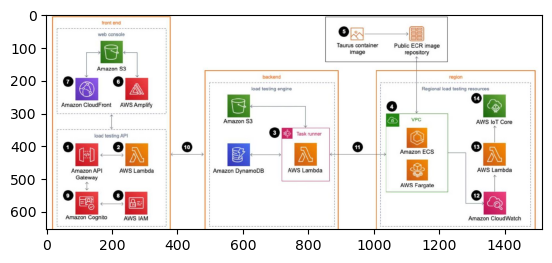


-----------------------------------------------
2. Category: Image, Chunk: 383 Characters
-----------------------------------------------


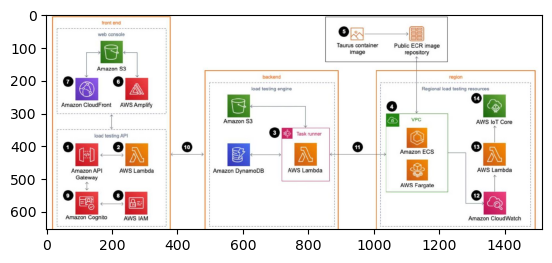


-----------------------------------------------
3. Category: CompositeElement, Chunk: 137 Characters
-----------------------------------------------

-----------------------------------------------
4. Category: CompositeElement, Chunk: 310 Characters
-----------------------------------------------

-----------------------------------------------
5. Category: CompositeElement, Chunk: 246 Characters
-----------------------------------------------


In [407]:
system_prompt = prompt_repo.get_system_prompt()

qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=True
)

#query = "vidio max size?"

query = "AWS의 부하테스트 솔루션은?"

response, contexts = qa.invoke(
    query = query,
    verbose=False
)


show_context_used(contexts)